### Import the necessary packages.

In [ ]:
!pip install -U klib

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
import klib # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import train and test dataset

In [4]:
train=pd.read_csv("/content/gdrive/MyDrive/deloitte_ml_challenge_predict_loan_defaulters./train.csv")


In [5]:
test=pd.read_csv("/content/gdrive/MyDrive/deloitte_ml_challenge_predict_loan_defaulters./test.csv")

#### The names of the columns **Employment Duration**,**Home Ownership** are interchanged.So, let's swap the column names.

In [6]:
train=train.rename(columns={'Employment Duration':'Home Ownership',
                            'Home Ownership':'Employment Duration'#     
                            })

test=test.rename(columns={'Employment Duration':'Home Ownership',
                            'Home Ownership':'Employment Duration'#                           
                            })

### Structure of the train and test dataset.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Home Ownership                67463 non-null  object 
 10  Employment Duration           67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

#### In train dataset there are 67463 data entries and 35 columns.

#### The target column is **Loan Status**.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28913 entries, 0 to 28912
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            28913 non-null  int64  
 1   Loan Amount                   28913 non-null  int64  
 2   Funded Amount                 28913 non-null  int64  
 3   Funded Amount Investor        28913 non-null  float64
 4   Term                          28913 non-null  int64  
 5   Batch Enrolled                28913 non-null  object 
 6   Interest Rate                 28913 non-null  float64
 7   Grade                         28913 non-null  object 
 8   Sub Grade                     28913 non-null  object 
 9   Home Ownership                28913 non-null  object 
 10  Employment Duration           28913 non-null  float64
 11  Verification Status           28913 non-null  object 
 12  Payment Plan                  28913 non-null  object 
 13  L

#### In test dataset there are 28913 data entries and 34 columns.

### Let's are there any missing values in any columns.

In [ ]:
train.isnull().sum()

ID                              0
Loan Amount                     0
Funded Amount                   0
Funded Amount Investor          0
Term                            0
Batch Enrolled                  0
Interest Rate                   0
Grade                           0
Sub Grade                       0
Home Ownership                  0
Employment Duration             0
Verification Status             0
Payment Plan                    0
Loan Title                      0
Debit to Income                 0
Delinquency - two years         0
Inquires - six months           0
Open Account                    0
Public Record                   0
Revolving Balance               0
Revolving Utilities             0
Total Accounts                  0
Initial List Status             0
Total Received Interest         0
Total Received Late Fee         0
Recoveries                      0
Collection Recovery Fee         0
Collection 12 months Medical    0
Application Type                0
Last week Pay 

In [ ]:
test.isnull().sum()

ID                                  0
Loan Amount                         0
Funded Amount                       0
Funded Amount Investor              0
Term                                0
Batch Enrolled                      0
Interest Rate                       0
Grade                               0
Sub Grade                           0
Employment Duration                 0
Home Ownership                      0
Verification Status                 0
Payment Plan                        0
Loan Title                          0
Debit to Income                     0
Delinquency - two years             0
Inquires - six months               0
Open Account                        0
Public Record                       0
Revolving Balance                   0
Revolving Utilities                 0
Total Accounts                      0
Initial List Status                 0
Total Received Interest             0
Total Received Late Fee             0
Recoveries                          0
Collection R

#### The above information shows that there are no missing values in both train and test dataset.

### Let's see the glimpse of train dataset.

In [ ]:
train.head(3)

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Home Ownership,Employment Duration,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0


### Let's see the distribution of the target columns(**Loan Staus**).

In [ ]:
def cat_plot(df,catcol,title='',**arg):
  _=plt.figure(figsize=(8,5))
  _=sns.countplot(data=df,x=catcol,order=df[catcol].value_counts().index,**arg)
  _=plt.title(title,fontsize=25)
  _=plt.xlabel(catcol,fontsize=15)
  _=plt.xticks(fontsize=10, rotation=90)

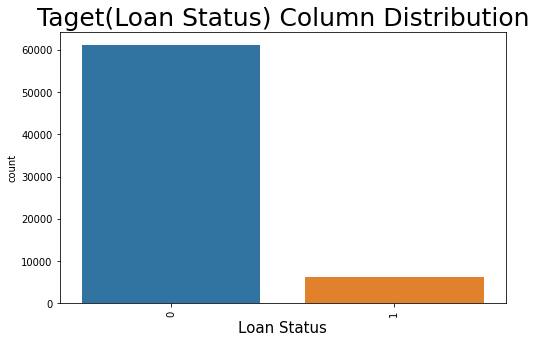

In [ ]:
cat_plot(train,"Loan Status" ,"Taget(Loan Status) Column Distribution")

In [ ]:
train["Loan Status"].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

#### The above distribtuion shows that there is a class imbalance between the two classes.
#### The distribution is biased to the **Class 0**.

#### Loan title contains so many repeated categories in lower and upper case letter foramt.So let's ignore the Loan Title column then plot remaining category columns. 

### Various types of enrollment batches and their loan status.

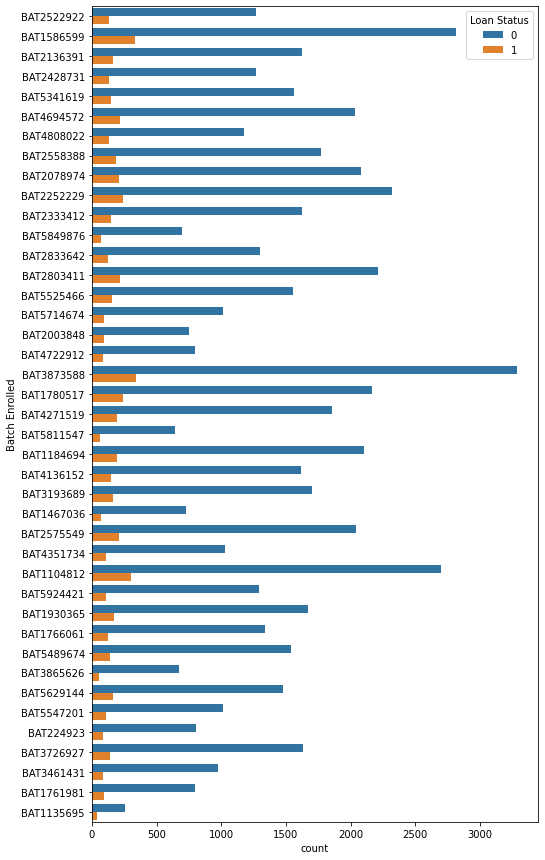

In [ ]:
_=plt.figure(figsize=(8,15))
_=sns.countplot(y=train['Batch Enrolled'],hue=train['Loan Status'].astype('object'))

In [ ]:
train.select_dtypes(include="object").columns.values

array(['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Payment Plan', 'Loan Title',
       'Initial List Status', 'Application Type'], dtype=object)

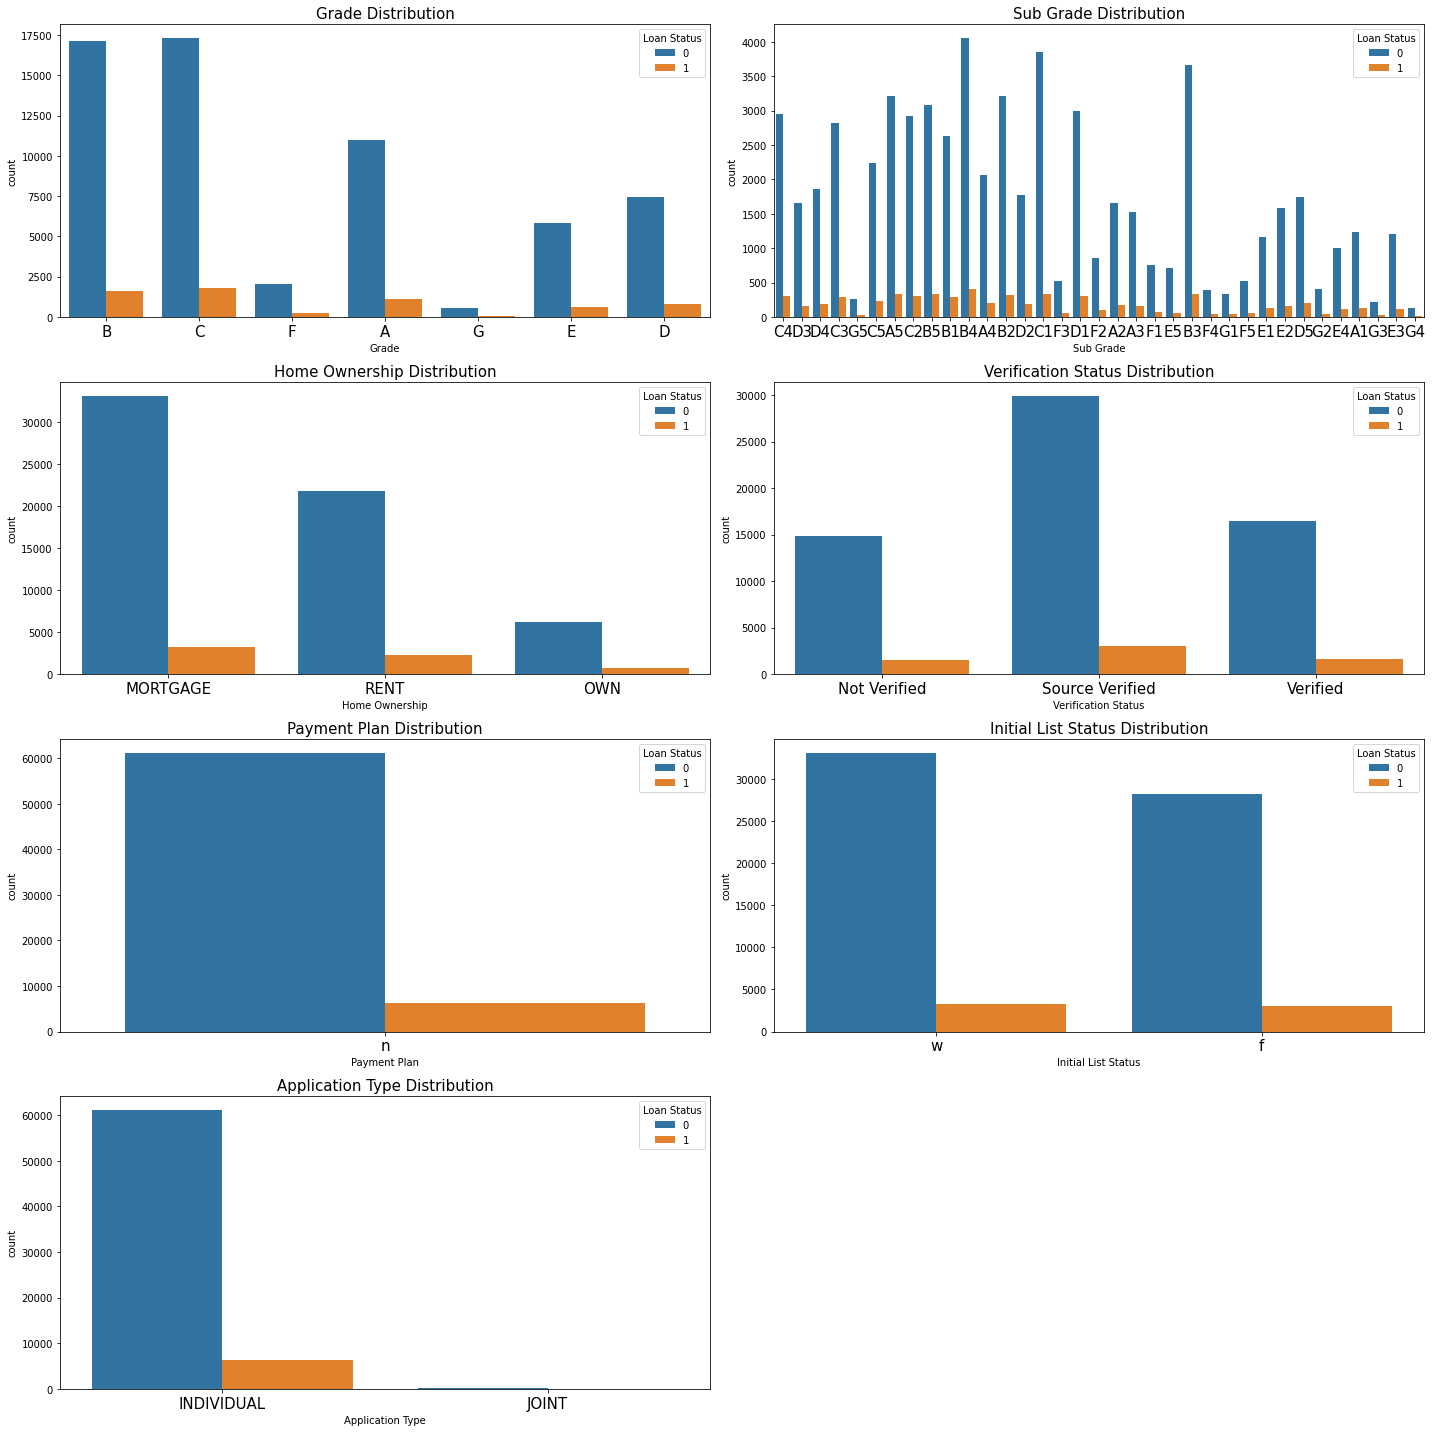

In [ ]:
fig=plt.subplots(figsize=(20, 20))
for i,col  in enumerate(['Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Payment Plan',
       'Initial List Status', 'Application Type']):    
       _=plt.subplot(4,2,i+1)
       _=sns.countplot(x=train[col],hue=train['Loan Status'].astype('object'))
       _=plt.title(col+' Distribution',fontsize=15)
       _=plt.xlabel(col,fontsize=10)
       _=plt.xticks(fontsize=15)
       _=plt.tight_layout()  
plt.show()           

In [ ]:
for col in train.select_dtypes(include="object").columns.values:
  print("=="*50)
  print(col)
  print(train[col].value_counts())
  print("=="*50)

Batch Enrolled
BAT3873588    3626
BAT1586599    3142
BAT1104812    2996
BAT2252229    2557
BAT2803411    2425
BAT1780517    2403
BAT1184694    2298
BAT2078974    2290
BAT2575549    2257
BAT4694572    2248
BAT4271519    2054
BAT2558388    1963
BAT3193689    1864
BAT1930365    1844
BAT2136391    1790
BAT2333412    1775
BAT3726927    1774
BAT4136152    1766
BAT5341619    1717
BAT5525466    1709
BAT5489674    1677
BAT5629144    1639
BAT1766061    1461
BAT2833642    1421
BAT5924421    1404
BAT2522922    1399
BAT2428731    1398
BAT4808022    1303
BAT4351734    1140
BAT5547201    1127
BAT5714674    1105
BAT3461431    1068
BAT224923      895
BAT1761981     894
BAT4722912     887
BAT2003848     842
BAT1467036     802
BAT5849876     768
BAT3865626     728
BAT5811547     711
BAT1135695     296
Name: Batch Enrolled, dtype: int64
Grade
C    19085
B    18742
A    12055
D     8259
E     6446
F     2246
G      630
Name: Grade, dtype: int64
Sub Grade
B4    4462
C1    4188
B3    3999
A5    3540
B2    35

#### The above bar chart explains that the payment plan contains only one category.

### Let's see the numerical columns distribution using histogram plot.

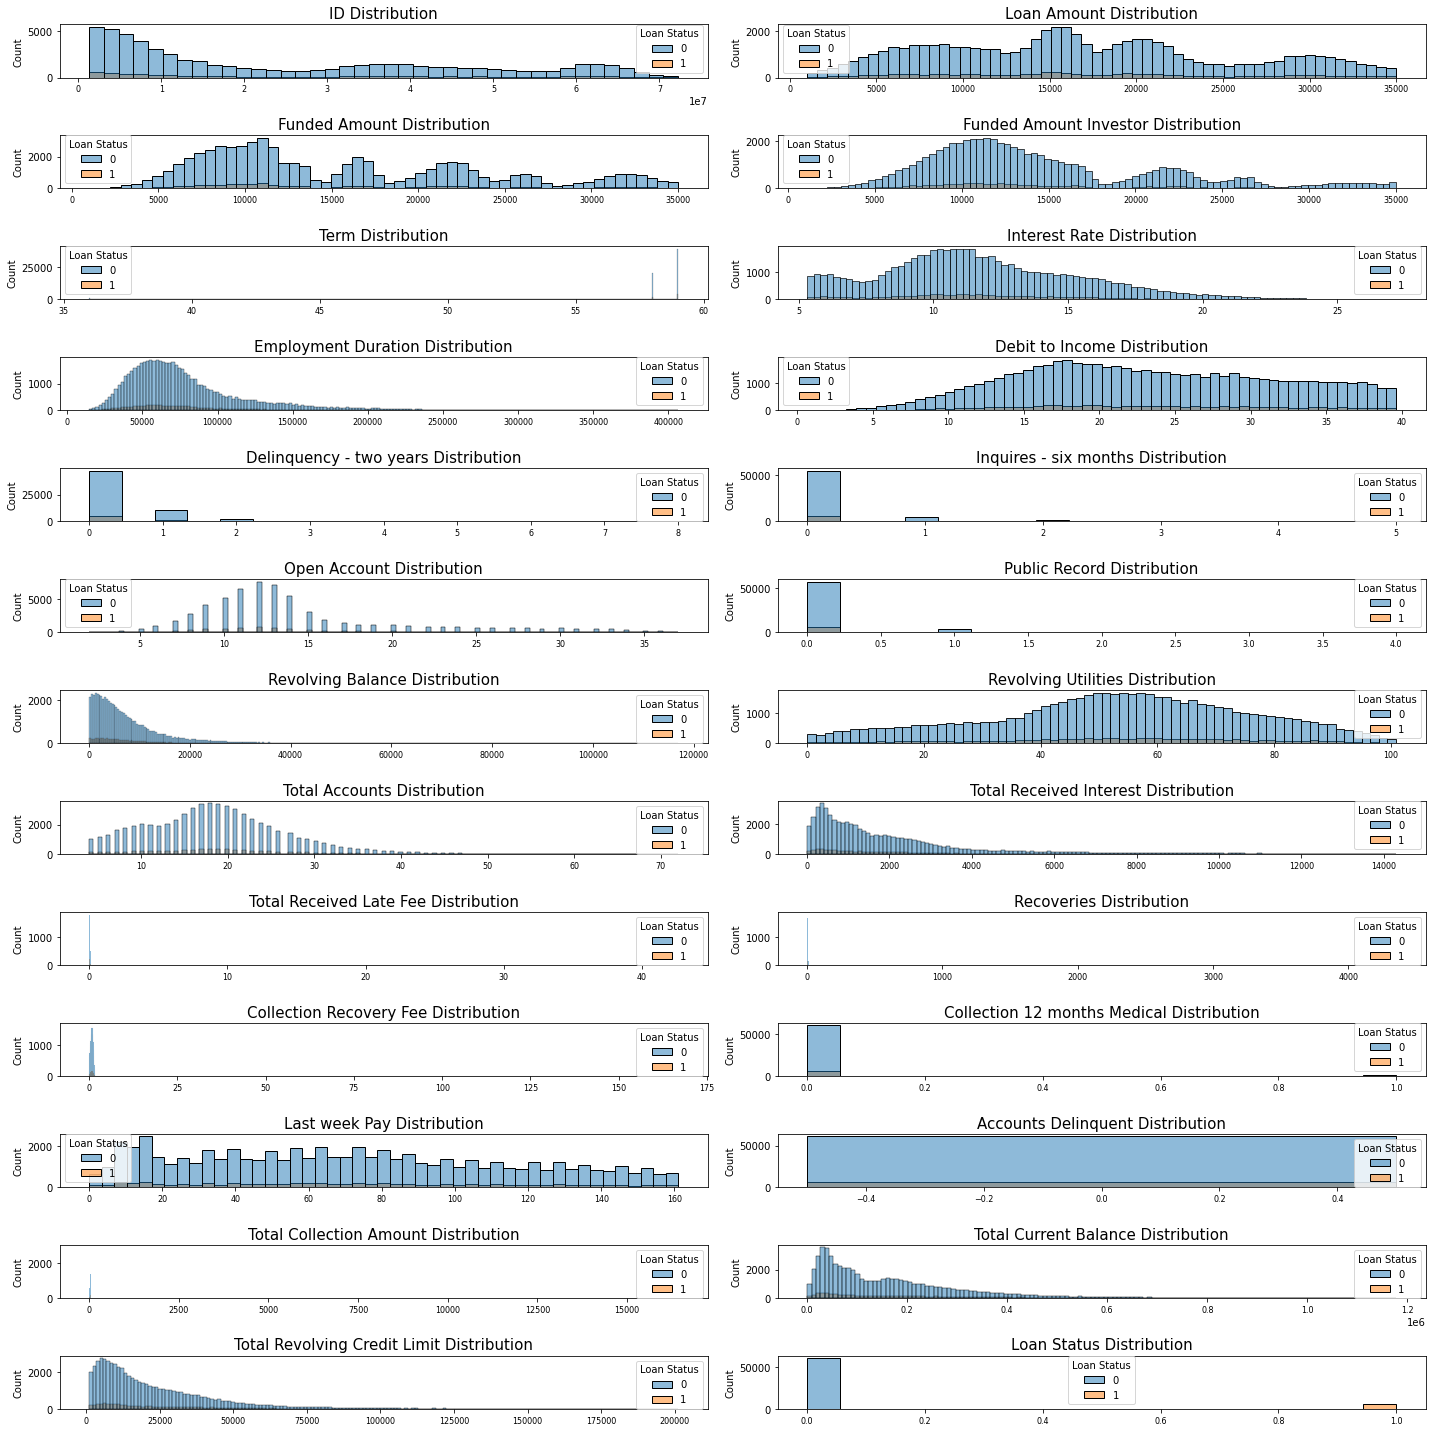

In [ ]:
fig=plt.subplots(figsize=(20, 20))
for i,col in enumerate(train.select_dtypes(exclude="object").columns.values):
  plt.subplot(13,2,i+1)
  _=sns.histplot(data=train,x=col,hue="Loan Status")
  _=plt.title(col+' Distribution',fontsize=15)
  _=plt.xlabel("")
  _=plt.xticks(fontsize=8)
  _=plt.tight_layout()
plt.show()        

In [ ]:
for col in train.select_dtypes(exclude="object").columns.values:
  print("=="*50)
  print(col)
  print(train[col].describe())
  print("=="*50)


ID
count    6.746300e+04
mean     2.562761e+07
std      2.109155e+07
min      1.297933e+06
25%      6.570288e+06
50%      1.791565e+07
75%      4.271521e+07
max      7.224578e+07
Name: ID, dtype: float64
Loan Amount
count    67463.000000
mean     16848.902776
std       8367.865726
min       1014.000000
25%      10012.000000
50%      16073.000000
75%      22106.000000
max      35000.000000
Name: Loan Amount, dtype: float64
Funded Amount
count    67463.000000
mean     15770.599114
std       8150.992662
min       1014.000000
25%       9266.500000
50%      13042.000000
75%      21793.000000
max      34999.000000
Name: Funded Amount, dtype: float64
Funded Amount Investor
count    67463.000000
mean     14621.799323
std       6785.345170
min       1114.590204
25%       9831.684984
50%      12793.682170
75%      17807.594120
max      34999.746430
Name: Funded Amount Investor, dtype: float64
Term
count    67463.000000
mean        58.173814
std          3.327441
min         36.000000
25%        

In [ ]:
train['Accounts Delinquent'].value_counts()

0    67463
Name: Accounts Delinquent, dtype: int64

#### The above histogram explains that the column Accounts Delinquent has same value(0- No delinqurnt) for all rows.

### Let's do some feature engineering task.

In [7]:
def pre_process(df):
  #drop the loan title and payment plan column
  df=df.drop(columns=['Loan Title','Payment Plan'])

  #Interest per month
  df['Interest_per_mon']=((df['Loan Amount']*df['Interest Rate'])/100)/df['Term']

  #total interest amount
  df['total_intr_amt']=df['Interest_per_mon']*df['Term']

  #Check investor funded amount greater than funded amount
  df['Fund_amnt_grt']=(df['Funded Amount Investor']>df['Funded Amount']).astype('int')

  #total revolve amount
  df['total_revolve']=df['Revolving Balance']+df['Revolving Utilities']
  
  #total received amount
  df['total_received']=df['Total Received Interest']+df['Total Collection Amount']
  
  #total recovery amount
  df['total_recovery']=df['Recoveries']+df['Collection Recovery Fee']
  
  #check total revolve amount less than total revolving credit limit
  df['revolve_amnt_grt']=(df['total_revolve']<df['Total Revolving Credit Limit']).astype('int')
  
  #check Loan amount greater than total current balance
  df['loan_grt_balance']=(df['Loan Amount']>df['Total Current Balance']).astype('int')

  #representative's customer count.
  df['reprs_cust_count']=df.groupby(['Batch Enrolled'])['Batch Enrolled'].transform('count')

  return df

### Apply the pre_process function to train data.

In [8]:
train=pre_process(train)

### Let's create new columns that shows groupby minimum, maximum and median of the numerical column

In [9]:
grpcol=['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Initial List Status', 'Application Type']

In [10]:
numcols=['Loan Amount', 'Funded Amount', 'Funded Amount Investor',
'Interest Rate', 'Employment Duration', 'Debit to Income',
'Open Account', 'Revolving Balance', 'Revolving Utilities',
'Total Accounts', 'Total Received Interest', 'Total Received Late Fee',
'Recoveries', 'Collection Recovery Fee',  'Total Collection Amount',
'Total Current Balance', 'Total Revolving Credit Limit',
'Interest_per_mon', 'total_intr_amt', 
        'total_revolve', 'total_received', 'total_recovery']

In [11]:
for col in numcols:
  df1=(train.groupby(grpcol)[col].
  agg({'min','median','max'}).reset_index())
  df1=df1.rename(columns={c:col+'_'+c for c in df1.loc[:,df1.columns.str.match("(min|median|max)")]})
  train=pd.merge(train,df1,on=grpcol,how='left')

### Let's see the total columns.

In [ ]:
for c, i in enumerate(train.columns.values):
  print(f"{c}_{i}")

0_ID
1_Loan Amount
2_Funded Amount
3_Funded Amount Investor
4_Term
5_Batch Enrolled
6_Interest Rate
7_Grade
8_Sub Grade
9_Home Ownership
10_Employment Duration
11_Verification Status
12_Debit to Income
13_Delinquency - two years
14_Inquires - six months
15_Open Account
16_Public Record
17_Revolving Balance
18_Revolving Utilities
19_Total Accounts
20_Initial List Status
21_Total Received Interest
22_Total Received Late Fee
23_Recoveries
24_Collection Recovery Fee
25_Collection 12 months Medical
26_Application Type
27_Last week Pay
28_Accounts Delinquent
29_Total Collection Amount
30_Total Current Balance
31_Total Revolving Credit Limit
32_Loan Status
33_Interest_per_mon
34_total_intr_amt
35_Fund_amnt_grt
36_total_revolve
37_total_received
38_total_recovery
39_revolve_amnt_grt
40_loan_grt_balance
41_reprs_cust_count
42_Loan Amount_max
43_Loan Amount_median
44_Loan Amount_min
45_Funded Amount_max
46_Funded Amount_median
47_Funded Amount_min
48_Funded Amount Investor_max
49_Funded Amount I

### Apply same pre_processing steps to test dataset.

In [12]:
test=pre_process(test)

In [13]:
for col in numcols:
  df1=(test.groupby(grpcol)[col].
  agg({'min','median','max'}).reset_index())
  df1=df1.rename(columns={c:col+'_'+c for c in df1.loc[:,df1.columns.str.match("(min|median|max)")]})
  test=pd.merge(test,df1,on=grpcol,how='left')

### Let's see the total columns.

In [ ]:
for c, i in enumerate(test.columns.values):
  print(f"{c}_{i}")

0_ID
1_Loan Amount
2_Funded Amount
3_Funded Amount Investor
4_Term
5_Batch Enrolled
6_Interest Rate
7_Grade
8_Sub Grade
9_Home Ownership
10_Employment Duration
11_Verification Status
12_Debit to Income
13_Delinquency - two years
14_Inquires - six months
15_Open Account
16_Public Record
17_Revolving Balance
18_Revolving Utilities
19_Total Accounts
20_Initial List Status
21_Total Received Interest
22_Total Received Late Fee
23_Recoveries
24_Collection Recovery Fee
25_Collection 12 months Medical
26_Application Type
27_Last week Pay
28_Accounts Delinquent
29_Total Collection Amount
30_Total Current Balance
31_Total Revolving Credit Limit
32_Loan Status
33_Interest_per_mon
34_total_intr_amt
35_Fund_amnt_grt
36_total_revolve
37_total_received
38_total_recovery
39_revolve_amnt_grt
40_loan_grt_balance
41_reprs_cust_count
42_Loan Amount_max
43_Loan Amount_median
44_Loan Amount_min
45_Funded Amount_max
46_Funded Amount_median
47_Funded Amount_min
48_Funded Amount Investor_max
49_Funded Amount I

### Let's create a catboost regressor model with optuna hyperparemeter optimization.

In [ ]:
!pip install optuna
!pip install catboost

### Import Necessary Packages

In [137]:
from sklearn.model_selection import  cross_val_score,KFold,train_test_split,ShuffleSplit,StratifiedKFold,learning_curve
from catboost import CatBoostClassifier,Pool,cv,monoforest
import optuna
from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import f1_score,classification_report,confusion_matrix,log_loss
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback,LightGBMPruningCallback
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures
import lightgbm as lgbm
import math

In [ ]:
for c, i in enumerate(train.columns.values):
  print(f"{c}_{i}")

0_ID
1_Loan Amount
2_Funded Amount
3_Funded Amount Investor
4_Term
5_Batch Enrolled
6_Interest Rate
7_Grade
8_Sub Grade
9_Home Ownership
10_Employment Duration
11_Verification Status
12_Debit to Income
13_Delinquency - two years
14_Inquires - six months
15_Open Account
16_Public Record
17_Revolving Balance
18_Revolving Utilities
19_Total Accounts
20_Initial List Status
21_Total Received Interest
22_Total Received Late Fee
23_Recoveries
24_Collection Recovery Fee
25_Collection 12 months Medical
26_Application Type
27_Last week Pay
28_Accounts Delinquent
29_Total Collection Amount
30_Total Current Balance
31_Total Revolving Credit Limit
32_Loan Status
33_Interest_per_mon
34_total_intr_amt
35_Fund_amnt_grt
36_total_revolve
37_total_received
38_total_recovery
39_revolve_amnt_grt
40_loan_grt_balance
41_reprs_cust_count
42_Loan Amount_min
43_Loan Amount_median
44_Loan Amount_max
45_Funded Amount_min
46_Funded Amount_median
47_Funded Amount_max
48_Funded Amount Investor_min
49_Funded Amount I

In [ ]:
train.select_dtypes(include='object').columns

Index(['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Initial List Status', 'Application Type'],
      dtype='object')

### Split predictor and target variables.

In [19]:
X=train.iloc[:,np.r_[1:32,33:108]]
y=train['Loan Status']

In [ ]:
train.select_dtypes(include='object').columns

Index(['Batch Enrolled', 'Grade', 'Sub Grade', 'Home Ownership',
       'Verification Status', 'Initial List Status', 'Application Type'],
      dtype='object')

### Define the model

In [ ]:
def objective(trial):
  skf = StratifiedKFold(n_splits=5,random_state=2000,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param = {
  
        'reg_lambda':trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0,150.0,200.0,250.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001,1.0),
        'n_estimators': trial.suggest_categorical('n_estimators',[200,400,600,800,1000]),
        'max_depth': trial.suggest_int('max_depth', 2,12),
        'random_state': trial.suggest_categorical('random_state', [1024, 1048,2020]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
        "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        }
  if param["bootstrap_type"] == "Bayesian":
    param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
    param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
  
  cat_clf = CatBoostClassifier(early_stopping_rounds=30,eval_metric="Logloss",
                               logging_level="Silent",
                              **param)
  cat_clf.fit(X_train, y_train,cat_features=['Batch Enrolled', 'Grade', 'Sub Grade',
                                             'Home Ownership','Verification Status', 
                                             'Initial List Status', 'Application Type'])
  
  preds = cat_clf.predict_proba(X_valid)
  accuracy = log_loss(y_valid, preds)
  return accuracy
  


if __name__ == "__main__":
    study = optuna.create_study(direction='minimize',sampler=MOTPESampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

[I 2021-12-28 13:19:48,727] A new study created in memory with name: no-name-dff88beb-72a5-48ec-a075-940e721f6802
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2021-12-28 13:21:38,488] Trial 0 finished with value: 0.4100010985018204 and parameters: {'reg_lambda': 200.0, 'learning_rate': 0.9552004688504021, 'n_estimators': 800, 'max_depth': 8, 'random_state': 2020, 'colsample_bylevel': 0.08140795734520816, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.4734171462679141}. Best is trial 0 with value: 0.4100010985018204.
[I 2021-12-28 13:22:04,720] Trial 1 finished with value: 0.31667966817519916 and parameters: {'reg_lambda': 50.0, 'learning_rate': 0.22908297508327882, 'n_estimators': 1000, 'max_depth': 8, 'random_state': 1024, 'colsample_bylevel': 0.010789467699509715, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.31667966817519916.
[I 2021-12-28 13:23:29,795] Trial 2 fini

Number of finished trials: 100
Best trial: {'reg_lambda': 250.0, 'learning_rate': 0.08580081062052972, 'n_estimators': 1000, 'max_depth': 2, 'random_state': 2020, 'colsample_bylevel': 0.010267520707686379, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0022013667340754}


In [ ]:
study.best_value

0.30730791194462437

In [ ]:
study.best_params

{'bagging_temperature': 2.0022013667340754,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.010267520707686379,
 'learning_rate': 0.08580081062052972,
 'max_depth': 2,
 'n_estimators': 1000,
 'random_state': 2020,
 'reg_lambda': 250.0}

### Visualizing the Optimization History - Explains the best score at each trails.

In [ ]:
optuna.visualization.plot_optimization_history(study)

### Visualizing High-dimensional Parameter Relationships

In [ ]:
optuna.visualization.plot_slice(study)

### Visualizing Parameter Importances

In [ ]:
optuna.visualization.plot_param_importances(study)

### Create a model with new parameters

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2,
                                                                         random_state = 42,
                                                      shuffle=True,stratify=y)

In [16]:
param_cat={'bagging_temperature': 2.0022013667340754,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'colsample_bylevel': 0.010267520707686379,
 'learning_rate': 0.08580081062052972,
 'max_depth': 2,
 'n_estimators': 1000,
 'random_state': 2020,
 'reg_lambda': 250.0}

In [103]:
cat_model = CatBoostClassifier(**param_cat,
                               eval_metric="Logloss",)

### Fit the model

In [ ]:
cat_model.fit(X_train,y_train,eval_set=(X_valid,y_valid),use_best_model=True,
         verbose=True,early_stopping_rounds=30,
              cat_features=['Batch Enrolled', 'Grade', 'Sub Grade',
                                             'Home Ownership','Verification Status', 
                                             'Initial List Status', 'Application Type'])

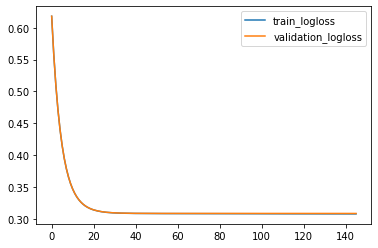

In [105]:
pd.DataFrame({'train_logloss':cat_model.evals_result_['learn']['Logloss'],
              'validation_logloss':cat_model.evals_result_['validation']['Logloss']}).plot()

### Import shap for model explaination

In [ ]:
!pip install shap

In [254]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(Pool(X,y,cat_features=['Batch Enrolled', 'Grade', 'Sub Grade',
                                             'Home Ownership','Verification Status', 
                                             'Initial List Status', 'Application Type']))

### Feature importance plot.

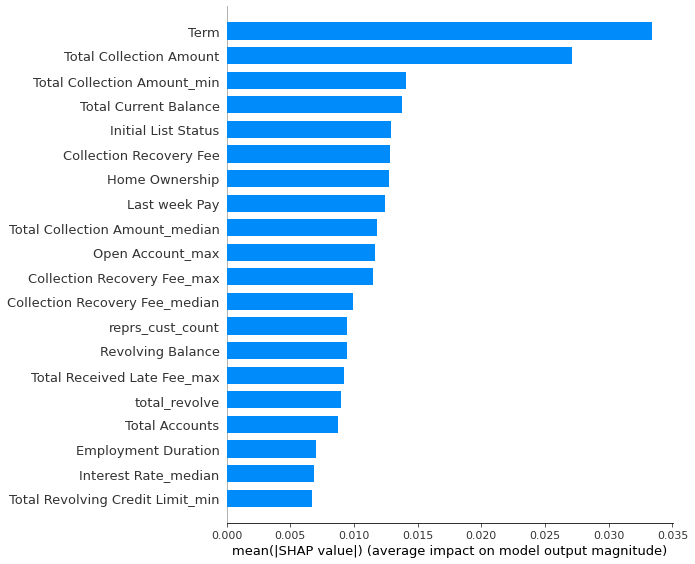

In [ ]:
shap.summary_plot(shap_values,X,class_names=['a','b'],plot_type ='bar')

### Top features impact the model

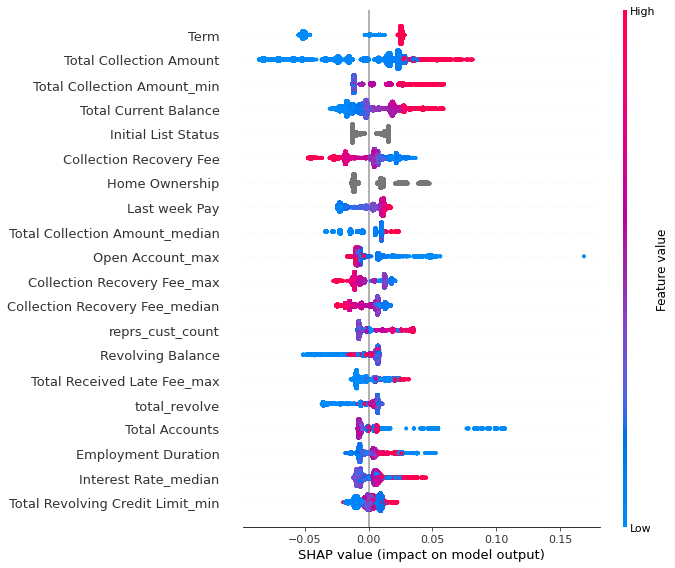

In [ ]:
shap.summary_plot(shap_values,X)

### Let's see which feature influences the model prediction for a single observation. 

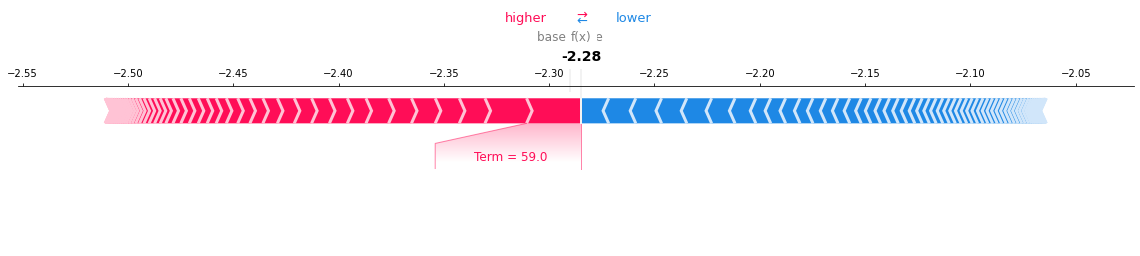

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:],matplotlib=True)

### Let's create a XGBoost classifier model optuna hyperparameter tuning

### XGboost can't handle the categorical input columns.So, let's use the LabelEncoder to encode the categorical columns.

In [124]:
lbl=LabelEncoder()

In [125]:
for i in X.select_dtypes(include='object').columns.values:
  X[i]=lbl.fit_transform(X[[i]])

In [ ]:
def objective(trial):
  skf = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": trial.suggest_categorical("tree_method",['exact', 'approx', 'hist']),
        "eta": trial.suggest_float("eta", 0.001, 1.0),

        #'interaction_constraints':[[2,3,8,12],[12,13,14],[5,6,9,12]],
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),

        "n_estimators":trial.suggest_categorical("n_estimators",[200,400,600,800,1000])
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 2, 60)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 60)
        
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-logloss")
    xgb_clf=XGBClassifier(early_stopping_rounds=50,
                               
                              **param)
    xgb_clf.fit(X_train,y_train,
               eval_set=[(X_valid, y_valid)],
            eval_metric='logloss',
            early_stopping_rounds=50,
            callbacks=[pruning_callback],
           
             )
    preds = xgb_clf.predict_proba(X_valid)
    accuracy = log_loss(y_valid, preds)
    return accuracy


if __name__ == "__main__":
    study1 = optuna.create_study(direction='minimize',sampler=RandomSampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study1.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study1.trials))
    print('Best trial:', study1.best_trial.params)  

In [ ]:
100*study1.best_value

30.745406896240347

In [ ]:
study1.best_params

{'alpha': 0.00013628501532199046,
 'booster': 'gbtree',
 'colsample_bytree': 0.4510459869291909,
 'eta': 0.23201860736451954,
 'gamma': 1.18221420230537e-05,
 'grow_policy': 'depthwise',
 'lambda': 7.036258743817963e-06,
 'max_depth': 6,
 'min_child_weight': 52,
 'n_estimators': 400,
 'subsample': 0.44069082236462886,
 'tree_method': 'exact'}

### Visualizing the Optimization History - Explains the best score at each trails.

In [ ]:
optuna.visualization.plot_optimization_history(study1)

### Visualizing High-dimensional Parameter Relationships

In [ ]:
optuna.visualization.plot_slice(study1)

### Visualizing Parameter Importances

In [ ]:
optuna.visualization.plot_param_importances(study1)

In [108]:
params_xgb={'alpha': 0.00013628501532199046,
 'booster': 'gbtree',
 'colsample_bytree': 0.4510459869291909,
 'eta': 0.23201860736451954,
 'gamma': 1.18221420230537e-05,
 'grow_policy': 'depthwise',
 'lambda': 7.036258743817963e-06,
 'max_depth': 6,
 'min_child_weight': 52,
 'n_estimators': 400,
 'subsample': 0.44069082236462886,
 'tree_method': 'exact'}



In [146]:
X.rename(columns=lambda x: x.replace(' ', '_'),inplace=True)

In [147]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X, y, test_size = 0.2,
                                                                         random_state = 42,
                                                      shuffle=True,stratify=y)

In [148]:
xgb_model=XGBClassifier(**params_xgb,verbose=1)

In [ ]:
xgb_model.fit(X_train1,y_train1,eval_set=[(X_valid1,y_valid1)],
              eval_metric='logloss',early_stopping_rounds=30,verbose=True)

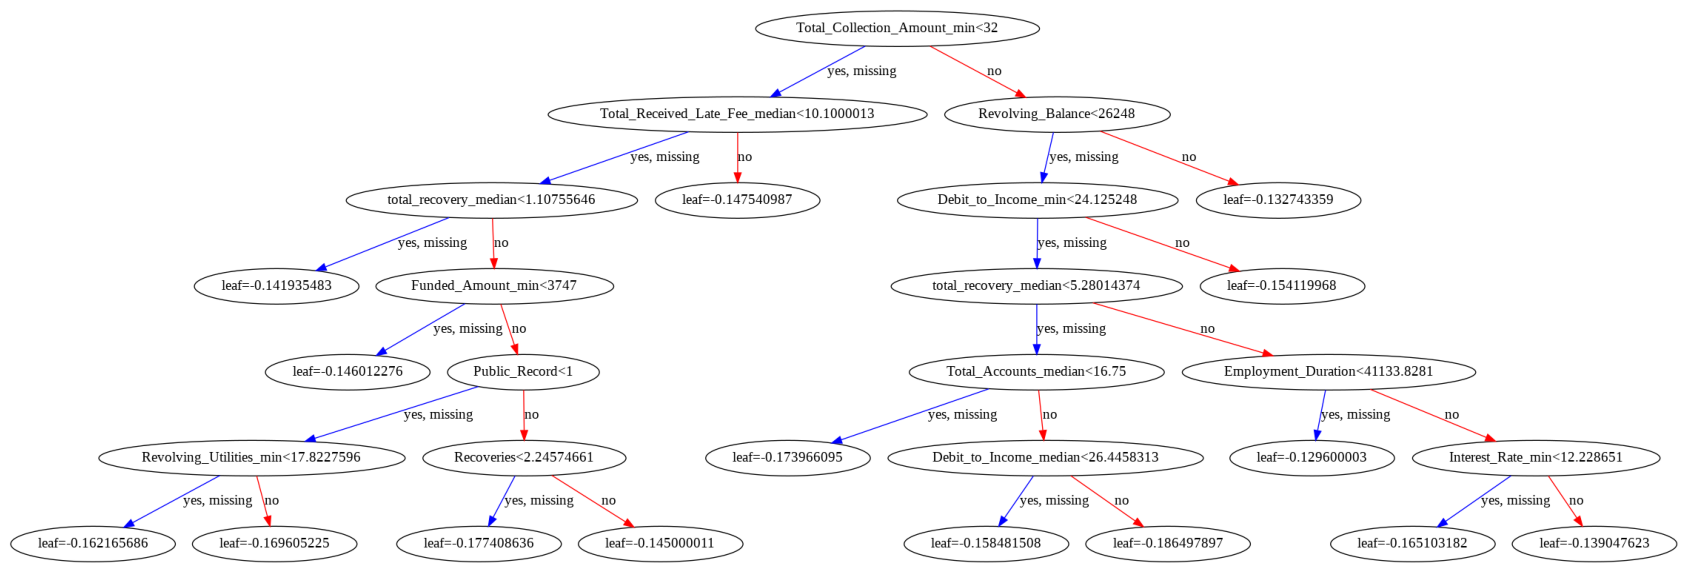

In [163]:

plot_tree(xgb_model)
fig = plt.gcf()
fig.set_size_inches(30, 30)

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X)

### Feature importance plot.

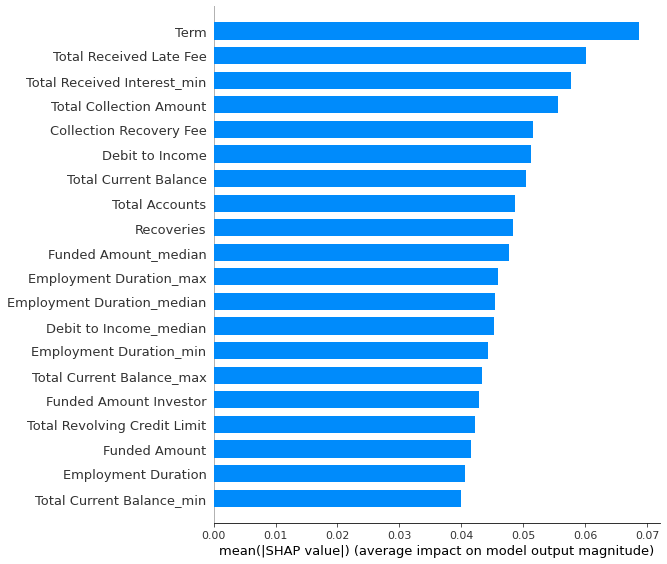

In [ ]:
shap.summary_plot(shap_values_xgb,X,plot_type ='bar')

### Let's create a LGBM classifier model optuna hyperparameter tuning

In [ ]:
def objective(trial):
  skf = StratifiedKFold(n_splits=10,random_state=22,shuffle=True)
  for i, (train_index, test_index) in enumerate(skf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "boosting_type":trial.suggest_categorical("boosting_type",['rf','gbdt']),
        "n_estimators": trial.suggest_categorical("n_estimators", [200,400,600,800,1000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 50),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100, ),
        "lambda_l1": trial.suggest_int("lambda_l1", 1, 1000 ),
        "lambda_l2": trial.suggest_int("lambda_l2", 1, 1000),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1,2,4,6,8,10]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }
    model = lgbm.LGBMClassifier(objective="binary", **param_grid)
    model.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],
            eval_metric='logloss',
            early_stopping_rounds=50,
            callbacks=[
               LightGBMPruningCallback(trial, 'binary_logloss')
            ],  # Add a pruning callback
        )
    preds = model.predict_proba(X_valid)
    score = log_loss(y_valid, preds)
    return 100*score


if __name__ == "__main__":
    study2 = optuna.create_study(direction='minimize',sampler=RandomSampler(),
           pruner=optuna.pruners.ThresholdPruner(lower=0.0))
    study2.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study2.trials))
    print('Best trial:', study2.best_trial.params)    

In [ ]:
study2.best_value

30.735793344814645

In [ ]:
study2.best_params

{'bagging_fraction': 0.7,
 'bagging_freq': 8,
 'boosting_type': 'rf',
 'feature_fraction': 0.4,
 'lambda_l1': 9,
 'lambda_l2': 517,
 'learning_rate': 0.30902486498872506,
 'max_depth': 4,
 'min_data_in_leaf': 7,
 'min_gain_to_split': 1.776112821650258,
 'n_estimators': 400,
 'num_leaves': 36,
 'random_state': 2020}

### Visualizing the Optimization History - Explains the best score at each trails.

In [ ]:
optuna.visualization.plot_optimization_history(study2)

### Visualizing High-dimensional Parameter Relationships

In [ ]:
optuna.visualization.plot_slice(study2)

### Visualizing Parameter Importances

In [ ]:
optuna.visualization.plot_param_importances(study2)

In [175]:
params_lgbm={'bagging_fraction': 0.7,
 'bagging_freq': 8,
 'boosting_type': 'rf',
 'feature_fraction': 0.4,
 'lambda_l1': 9,
 'lambda_l2': 517,
 'learning_rate': 0.30902486498872506,
 'max_depth': 4,
 'min_data_in_leaf': 7,
 'min_gain_to_split': 1.776112821650258,
 'n_estimators': 400,
 'num_leaves': 36,
 'random_state': 2020}

In [176]:
lgb_model=lgbm.LGBMClassifier(objective="binary", **params_lgbm)

In [ ]:
lgb_model.fit(X_train1,y_train1,eval_set=[(X_valid1,y_valid1)],
              eval_metric='logloss',early_stopping_rounds=30)

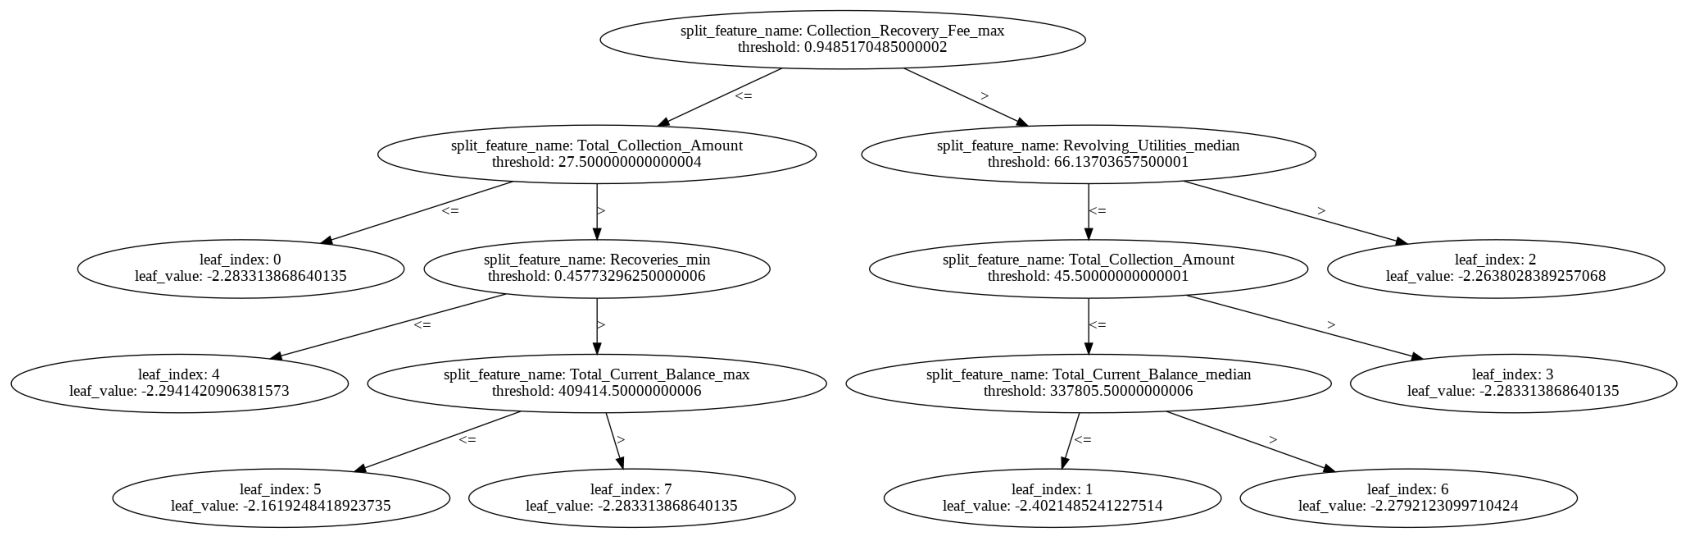

In [179]:
lgbm.plot_tree(lgb_model)
fig = plt.gcf()
fig.set_size_inches(30, 30)

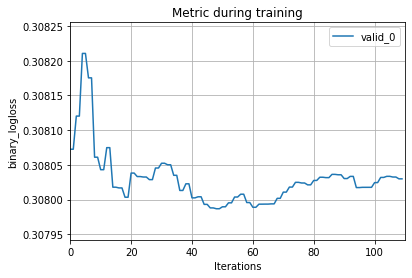

In [181]:
lgbm.plot_metric(lgb_model)

In [ ]:
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X)

### Feature importance plot.

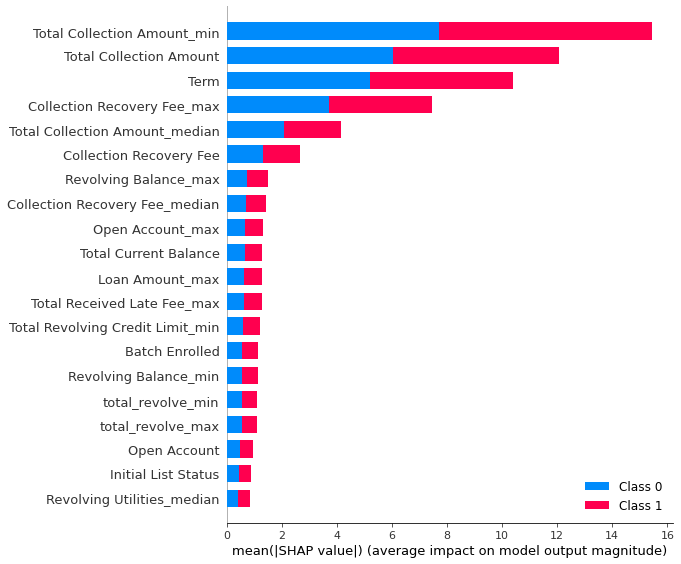

In [ ]:
shap.summary_plot(shap_values_lgb,X,plot_type ='bar')

### The ensemble models resuls are almost same.Let's try neural network model and see is there any improvement.

### For neural model the input values should be scalled.

In [188]:
scl=StandardScaler()

In [189]:
for i in X.select_dtypes(exclude='object').columns.values:
  X[i]=scl.fit_transform(X[[i]])

In [187]:
from tensorflow import keras
from tensorflow.keras import layers

In [235]:
nn = keras.Sequential([
    layers.BatchNormalization(input_shape = [X.shape[1]]),
    layers.Dense(units = 128, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.5),
    layers.Dense(units = 64, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.4),
    layers.Dense(units = 32, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),
    layers.Dense(units = 1, activation = 'sigmoid')
])

In [236]:
auc = keras.metrics.BinaryAccuracy()
nn.compile(optimizer = keras.optimizers.Adam(),
loss = keras.losses.BinaryCrossentropy(),
metrics = [auc])

In [293]:
early_stopping = keras.callbacks.EarlyStopping(patience = 20,
                                min_delta = 0.001,
                                restore_best_weights = False)

In [300]:
initial_learning_rate = 0.01
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [301]:
callback_lr = keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [ ]:
history =nn.fit(X, y,
                   validation_split=0.2,
                   batch_size = 64,
                   epochs = 100,
                   callbacks = [early_stopping,callback_lr
                                ]
                 )


In [303]:
history_df = pd.DataFrame(history.history)

In [354]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.305598,0.906782,0.305026,0.910176,0.01
1,0.306870,0.906819,0.305177,0.910176,0.01
2,0.306987,0.906819,0.303225,0.910176,0.01
3,0.307738,0.906819,0.302526,0.910176,0.01
4,0.307743,0.906837,0.302042,0.910176,0.01


Text(0.5, 1.0, "Model's Validation-Logloss Comparison")

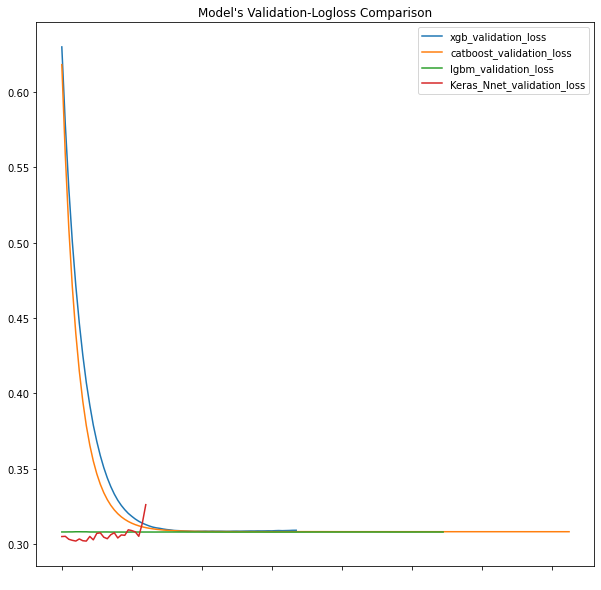

In [304]:
plt.figure(figsize=(10,10))
plt.plot(xgb_model.evals_result_['validation_0']['logloss'],label="xgb_validation_loss")
plt.plot(cat_model.evals_result_['validation']['Logloss'],label="catboost_validation_loss")
plt.plot(lgb_model.evals_result_['valid_0']['binary_logloss'],label="lgbm_validation_loss")
plt.plot(history_df['val_loss'],label="Keras_Nnet_validation_loss")
plt.legend()
plt.xticks(color='w')
plt.title("Model's Validation-Logloss Comparison")

#### For this data, the neural network model performs better compared to ensemble models.